## Imports

In [80]:
import pandas as pd
import numpy as np
from pandarallel import pandarallel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import HashingVectorizer
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import time
print('imports done.')

imports done.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data loading and pre-processing

In [85]:
movie_reviews_dataset = pd.read_json('../dataset_management/basic_dataset.json')

# Transpose dataset to put IDs as rows and have 3 columns instead.
movie_reviews_dataset = movie_reviews_dataset.T

movie_reviews_dataset.head()

,review,rating,label
3fbe21c4-3046-4b12-abc0-77ebdfaf09b1,I was completely mesmerized by Lekin and espec...,9/10,Positive
3ff18551-e522-4de2-ba9d-0d11387e62ba,Greatly enjoyed the development of the story l...,9/10,Positive
ee8306d6-acc4-4b8f-a333-2c86552de3ea,"In Lekin, Sameer, a museum curator working for...",9/10,Positive
9edd5843-c446-4985-80c7-dbfe0b90dd1b,"The lines of time are very blurry. Past, prese...",10/10,Positive
cf960381-1782-40a0-a870-435d9f636d09,Yaara Sili Sili Virah Ki Raat Ka Jalna'Lekin' ...,8/10,Positive


In [22]:
movie_reviews_dataset['review'].iloc[0]

"I was completely mesmerized by Lekin and especially by the castle and Dimple's haunting character who took over the screen whenever she materialized. It brought back memories of Ugetsu, one of my favorite Japanese films. The photography, the music, story, acting was all top notch and I am definitely going to have to see what else Gulzar did. The desert, itself, was as much a character as any of the actors. I would have given Lekin a 10 but, since I do not know Hindi, I have to rely on subtitles and, periodically, the subtitles were a little hard to follow unless you are a speed reader. Also, my biggest gripe with a lot of great Hindi films is that they do not include the subtitles to the songs which was the case on my DVD. I was unable to see for myself why Gulzar won two awards for best lyrics that year. It was also frustrating because, when Dimple's character sang, I am almost certain that knowing the lyrics would have only added to the enjoyment of the film. I still gave Lekin a 9 

In [23]:
len(movie_reviews_dataset)

14998

In [35]:
# Check for NaN values and remove them
print("NaN (before cleanup) ?: \n", movie_reviews_dataset.isnull().sum())

movie_reviews_dataset['review'] = movie_reviews_dataset['review'].fillna('')

print("NaN (after cleanup) ?: \n", movie_reviews_dataset.isnull().sum())

NaN (before cleanup) ?: 
 review    0
rating    0
label     0
dtype: int64
NaN (after cleanup) ?: 
 review    0
rating    0
label     0
dtype: int64


In [38]:
# Text preprocessing for review column
# Lower all text

movie_reviews_dataset['review'] = movie_reviews_dataset['review'].str.lower()

# Initialize pandarallel
# I used pandarallel because it applies the functions much faster than a normal pandas apply.
pandarallel.initialize(nb_workers=4,progress_bar=True)

# Remove all special characters
def remove_special_chars(text):
    return ''.join(x if x.isalnum() else ' ' for x in text)

movie_reviews_dataset['review'] = movie_reviews_dataset['review'].parallel_apply(remove_special_chars)

# get stopwords.
stop_words = set(stopwords.words('english'))

# Remove stop_words
def remove_stopwords(text):
    words = word_tokenize(text)
    return [x for x in words if x not in stop_words]


movie_reviews_dataset['review'] = movie_reviews_dataset['review'].apply(remove_stopwords)

# Lemmatization
def lemmatize_word(text):
    wordnet = WordNetLemmatizer()
    return " ".join([wordnet.lemmatize(word) for word in text])


movie_reviews_dataset['review'] = movie_reviews_dataset['review'].apply(lemmatize_word)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

movie_reviews_dataset['review'] = movie_reviews_dataset['review'].apply(remove_numbers)

print('Example of preprocessing train: ')
print(movie_reviews_dataset['review'].iloc[0])

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


Example of preprocessing train: 
completely mesmerized lekin especially castle dimple haunting character took screen whenever materialized brought back memory ugetsu one favorite japanese film photography music story acting top notch definitely going see else gulzar desert much character actor would given lekin since know hindi rely subtitle periodically subtitle little hard follow unless speed reader also biggest gripe lot great hindi film include subtitle song case dvd unable see gulzar two award best lyric year also frustrating dimple character sang almost certain knowing lyric would added enjoyment film still gave lekin anyone tell easily find lyric would grateful


## Model creation and evaluation

In [90]:
X = movie_reviews_dataset['review']
Y = movie_reviews_dataset['label']
vectorizer = HashingVectorizer()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
print('data vectorization complete.')

data vectorization complete.


In [70]:
clf = LogisticRegression(penalty='l1', solver='saga', C=1.0, max_iter=1000, multi_class='multinomial')
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', penalty='l1',
                   solver='saga')

In [71]:
y_pred = clf.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cnf_matrix)

print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[ 298   74  206]
 [  77  114  408]
 [  51   72 1700]]

Classification Report:
               precision    recall  f1-score   support

    Negative       0.70      0.52      0.59       578
     Neutral       0.44      0.19      0.27       599
    Positive       0.73      0.93      0.82      1823

    accuracy                           0.70      3000
   macro avg       0.62      0.55      0.56      3000
weighted avg       0.67      0.70      0.67      3000



## Hyperparameter tuning

In [75]:
start_time = time.time()
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Penalty type
    'solver': ['liblinear', 'saga']  # Solver method
}

log_reg = LogisticRegression(multi_class='auto', max_iter=1000)


grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed Time for grid_search:", elapsed_time, "seconds")

print("Best Hyperparameters:", grid_search.best_params_)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was re

Best Hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [78]:
best_hyper_log_reg = LogisticRegression(multi_class='auto', max_iter=1000, C=10, penalty='l2', solver='liblinear')
best_hyper_log_reg.fit(X_train, y_train)

y_pred = best_hyper_log_reg.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cnf_matrix)

print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[ 334   88  156]
 [  89  161  349]
 [  56  112 1655]]

Classification Report:
               precision    recall  f1-score   support

    Negative       0.70      0.58      0.63       578
     Neutral       0.45      0.27      0.34       599
    Positive       0.77      0.91      0.83      1823

    accuracy                           0.72      3000
   macro avg       0.64      0.58      0.60      3000
weighted avg       0.69      0.72      0.69      3000



### We get a 2% increase in total accuracy using the best hyperparameters, however in the Learning curve below we noticed that if we use the best hyperparams the model is overfitting. Therefore, we will keep the initial model (clf) with the saga solver, L1 regularization penalty and regularization strength (C) = 1.0

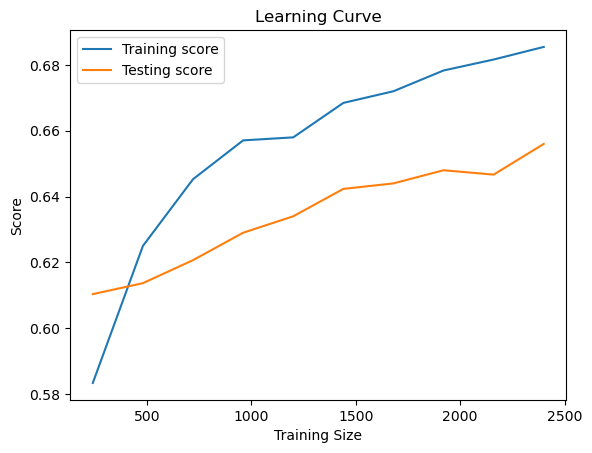

Elapsed Time for learning curve creation: 116.01298236846924 seconds


In [82]:
# Learning curve
start_time = time.time()
def plot_learning_curve(X, y, estimator, train_sizes=np.linspace(0.1, 1.0, 10), cv=5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=train_sizes, cv=cv)

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, test_scores_mean, label='Testing score')

    plt.title('Learning Curve')
    plt.xlabel('Training Size')
    plt.ylabel('Score')
    plt.legend()
    plt.show()
    
plot_learning_curve(X_test, y_test, clf)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed Time for learning curve creation:", elapsed_time, "seconds")